In [1]:
!pip install igraph
!pip install import_ipynb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import networkx as nx
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import numpy as np
import time as time
from random import uniform, seed
from igraph import *

import import_ipynb
import Models as models

import pickle
import json

In [50]:
AAAA = Graph.Read_GML('PB2020.gml')

G = nx.read_gml('PB2020.gml')
G = G.reverse()

pb2020 = Graph.from_networkx(G)

https://github.com/hautahi/IM_GreedyCELF 


# CELF

In [11]:
def compute_spread(g,S,p=0.5,mc=10):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [12]:
def celf(g,k,p=0.1,mc=10):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [compute_spread(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,compute_spread(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

# Independent Cascade

In [21]:
# read from gml
Independent_Cascade = models.Independent_Cascade()
Independent_Cascade.fit(G)

# remove all 0 from model.probability which is ndarray
p_Independent_Cascade = Independent_Cascade.probability[Independent_Cascade.probability != 0]
celf_output_Independent_Cascade = celf(pb2020, 10, p = np.mean(p_Independent_Cascade), mc = 100)

In [29]:
celf_output_Independent_Cascade

([6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020],
 [170.2,
  253.03,
  317.62,
  363.09,
  386.08,
  408.94,
  424.89,
  435.74,
  443.45,
  447.95],
 [344.4998607635498,
  346.55245637893677,
  437.0093924999237,
  867.3340129852295,
  6382.0392735004425,
  6384.444064378738,
  6538.080604553223,
  8721.390319108963,
  8746.713278532028,
  8777.18513250351],
 [13217, 5, 185, 763, 4546, 1, 66, 1381, 44, 52])

In [23]:
pickle_Independent_Cascade = pickle.dumps(celf_output_Independent_Cascade)

with open('pickle_Independent_Cascade.pickle', 'wb') as handle:
    pickle.dump(pickle_Independent_Cascade, handle)

In [24]:
with open('Independent_Cascade.json', 'w') as fjson:
    json.dump(celf_output_Independent_Cascade, fjson)

In [32]:
AAAAA = Graph.Read_GML('PB2020.gml')

In [33]:
for i in celf_output_Independent_Cascade[0]:
    print(AAAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon


In [22]:
print("The optimal seed set is: ", celf_output_Independent_Cascade[0])
print("The resulting spread is: ", celf_output_Independent_Cascade[1])
print("The time for each iteration is: ", celf_output_Independent_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Independent_Cascade[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020]
The resulting spread is:  [170.2, 253.03, 317.62, 363.09, 386.08, 408.94, 424.89, 435.74, 443.45, 447.95]
The time for each iteration is:  [344.4998607635498, 346.55245637893677, 437.0093924999237, 867.3340129852295, 6382.0392735004425, 6384.444064378738, 6538.080604553223, 8721.390319108963, 8746.713278532028, 8777.18513250351]
The number of times the spread is computed is:  [13217, 5, 185, 763, 4546, 1, 66, 1381, 44, 52]


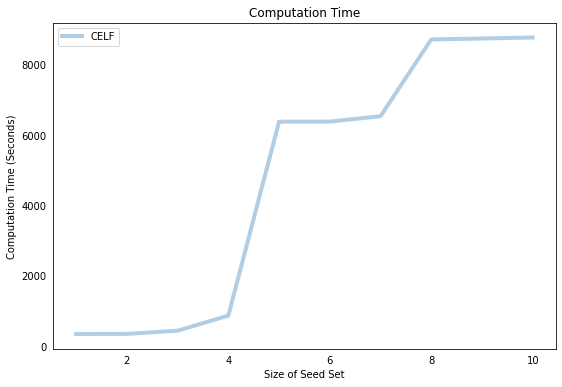

In [30]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Independent_Cascade[2])+1),celf_output_Independent_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

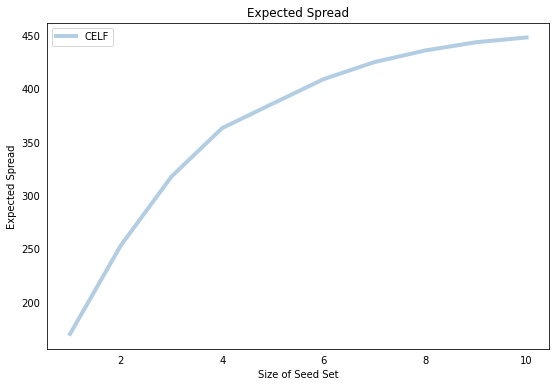

In [31]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Independent_Cascade[1])+1),celf_output_Independent_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Decreasing Cascade

In [35]:
# read from gml
Decreasing_Cascade = models.Decreasing_Cascade()
Decreasing_Cascade.fit(G)

# remove all 0 from model.probability which is ndarray
p_Decreasing_Cascade = Decreasing_Cascade.probability[Decreasing_Cascade.probability != 0]
celf_output_Decreasing_Cascade = celf(pb2020, 20, p = np.mean(p_Decreasing_Cascade), mc = 100)

In [36]:
pickle_Decreasing_Cascade = pickle.dumps(celf_output_Decreasing_Cascade)

with open('pickle_Decreasing_Cascade.pickle', 'wb') as handle:
    pickle.dump(pickle_Decreasing_Cascade, handle)

In [37]:
with open('Decreasing_Cascade.json', 'w') as fjson:
    json.dump(celf_output_Decreasing_Cascade, fjson)

In [42]:
for i in celf_output_Decreasing_Cascade[0]:
    print(AAAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon
DetroitProudBoy
Father_Rhyme
ColoradoPOYB
Proudboy13
decentbastards
adamciferri
GregoryKuhnJr1
guns4lyf
ashymadison
usa_chopper


In [43]:
print("The optimal seed set is: ", celf_output_Decreasing_Cascade[0])
print("The resulting spread is: ", celf_output_Decreasing_Cascade[1])
print("The time for each iteration is: ", celf_output_Decreasing_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Decreasing_Cascade[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020, 21, 1485, 0, 7154, 6349, 8667, 11989, 8060, 6336, 2074]
The resulting spread is:  [170.2, 253.03, 317.62, 363.09, 386.08, 408.94, 424.89, 435.74, 443.45, 447.95, 451.52, 454.29, 456.1, 457.62, 459.13, 460.5, 461.77, 463.01, 464.23, 465.44]
The time for each iteration is:  [511.4944884777069, 514.4299976825714, 639.2418484687805, 1228.0951483249664, 3437.57008934021, 3438.1029143333435, 3473.423464536667, 4748.953769445419, 4795.781750202179, 4852.191705465317, 5593.689623117447, 5605.836257219315, 6381.289360284805, 6550.382925748825, 6550.977323293686, 7143.006497144699, 11978.454059839249, 12129.352005004883, 12130.174284696579, 12140.0514087677]
The number of times the spread is computed is:  [13217, 5, 185, 763, 4546, 1, 66, 1381, 44, 52, 686, 11, 919, 283, 1, 888, 4932, 184, 1, 12]


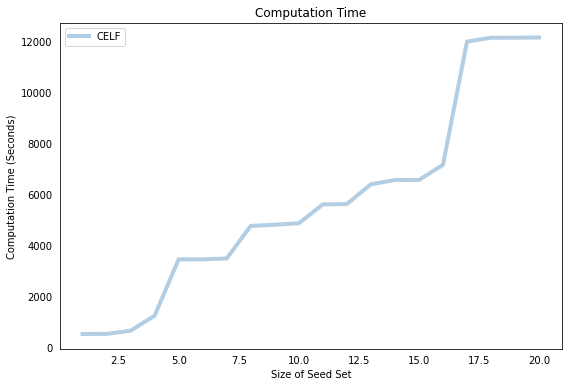

In [44]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Decreasing_Cascade[2])+1),celf_output_Decreasing_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

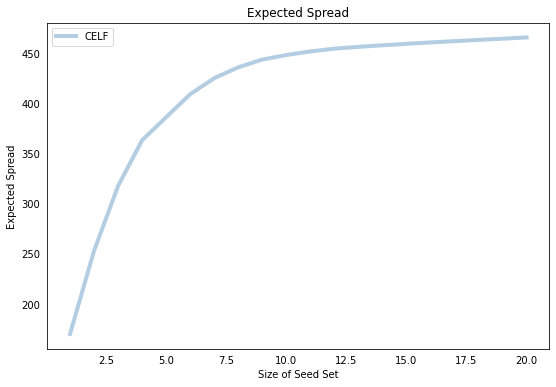

In [45]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Decreasing_Cascade[1])+1),celf_output_Decreasing_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# WCM

In [13]:
# read from gml
Weighted_Cascade = models.Weighted_Cascade()
Weighted_Cascade.fit(G)

# remove all 0 from model.probability which is ndarray
p_Weighted_Cascade = Weighted_Cascade.probability[Weighted_Cascade.probability != 0]
celf_output_Weighted_Cascade = celf(pb2020, 20, p = np.mean(p_Weighted_Cascade), mc = 100)

In [14]:
pickle_Weighted_Cascade = pickle.dumps(celf_output_Weighted_Cascade)

with open('pickle_Weighted_Cascade.pickle', 'wb') as handle:
    pickle.dump(pickle_Weighted_Cascade, handle)

In [15]:
with open('Weighted_Cascade.json', 'w') as fjson:
    json.dump(celf_output_Weighted_Cascade, fjson)

In [49]:
for i in celf_output_Weighted_Cascade[0]:
    print(AAAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon
DetroitProudBoy
Father_Rhyme
ColoradoPOYB
cckrch
decentbastards
Proudboy13
American_Greg
GregoryKuhnJr1
Sj71Steven
usa_chopper


In [16]:
print("The optimal seed set is: ", celf_output_Weighted_Cascade[0])
print("The resulting spread is: ", celf_output_Weighted_Cascade[1])
print("The time for each iteration is: ", celf_output_Weighted_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Weighted_Cascade[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020, 21, 1485, 0, 8675, 6349, 7154, 11242, 11989, 7471, 2074]
The resulting spread is:  [71.85, 115.59, 148.19, 171.6, 185.37, 197.67, 206.17, 212.21, 216.92, 219.7, 222.17, 223.99, 225.48, 226.86, 228.12, 229.37, 230.53, 231.67, 232.81, 233.94]
The time for each iteration is:  [79.57531762123108, 79.77191162109375, 80.02083683013916, 80.30128121376038, 81.43490600585938, 82.3844804763794, 281.99675488471985, 1902.8412973880768, 1903.1792125701904, 2426.4930367469788, 2441.1017248630524, 2538.7851662635803, 2736.1050589084625, 3096.2849140167236, 3555.2561049461365, 3555.6598765850067, 3562.7978432178497, 5185.1979830265045, 5255.73091673851, 5256.563062906265]
The number of times the spread is computed is:  [13217, 1, 1, 1, 4, 3, 603, 4705, 1, 1433, 41, 255, 484, 912, 1151, 1, 18, 4038, 184, 2]


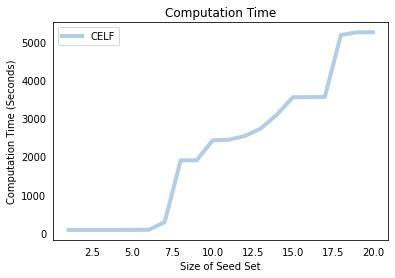

In [17]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Weighted_Cascade[2])+1),celf_output_Weighted_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

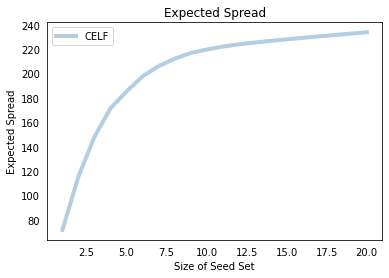

In [18]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Weighted_Cascade[1])+1),celf_output_Weighted_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Trivalency 

In [19]:
# read from gml
Trivalency_Model = models.Trivalency_Model()
Trivalency_Model.fit(G)

# remove all 0 from model.probability which is ndarray
p_Trivalency_Model = Trivalency_Model.probability[Trivalency_Model.probability != 0]
celf_output_Trivalency_Model = celf(pb2020, 20, p = np.mean(p_Trivalency_Model), mc = 100)

In [20]:
pickle_Trivalency_Model = pickle.dumps(celf_output_Trivalency_Model)

with open('pickle_Trivalency_Model.pickle', 'wb') as handle:
    pickle.dump(pickle_Trivalency_Model, handle)

In [21]:
with open('Trivalency_Model.json', 'w') as fjson:
    json.dump(celf_output_Trivalency_Model, fjson)

In [53]:
f = open('Trivalency_Model.json')
celf_output_Trivalency_Model = json.load(f)
li = celf_output_Trivalency_Model[0]

for i in li:
    print(AAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon
DetroitProudBoy
Father_Rhyme
ColoradoPOYB
cckrch
decentbastards
American_Greg
Proudboy13
guns4lyf
KowalskiRandy
ashymadison


In [54]:
print("The optimal seed set is: ", celf_output_Trivalency_Model[0])
print("The resulting spread is: ", celf_output_Trivalency_Model[1])
print("The time for each iteration is: ", celf_output_Trivalency_Model[2])
print("The number of times the spread is computed is: ", celf_output_Trivalency_Model[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020, 21, 1485, 0, 8675, 6349, 11242, 7154, 8060, 1113, 6336]
The resulting spread is:  [23.19, 38.11, 49.26, 57.72, 63.19, 67.88, 71.25, 73.92, 76.15, 77.75, 79.25, 80.49, 81.7, 82.83, 83.92, 85.0, 86.08, 87.14, 88.19, 89.24]
The time for each iteration is:  [29.104891061782837, 29.1684730052948, 29.247025966644287, 29.352786779403687, 29.452685356140137, 29.56034779548645, 29.672269344329834, 30.205024480819702, 30.33803081512451, 118.02567839622498, 118.18523168563843, 773.3544864654541, 802.4098460674286, 1011.0607059001923, 1187.8378012180328, 1267.7748413085938, 1268.2703223228455, 1268.8022413253784, 1313.2873821258545, 1313.4509489536285]
The number of times the spread is computed is:  [13217, 1, 1, 1, 1, 1, 1, 4, 1, 606, 1, 4574, 198, 1415, 1137, 496, 3, 3, 268, 1]


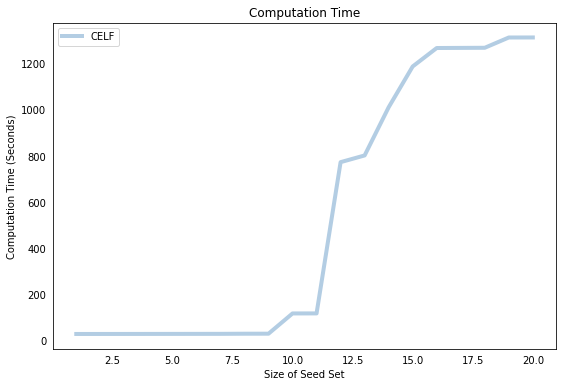

In [55]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Trivalency_Model[2])+1),celf_output_Trivalency_Model[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

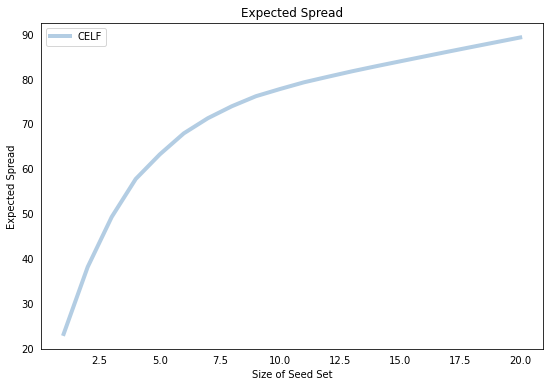

In [24]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Trivalency_Model[1])+1),celf_output_Trivalency_Model[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Generalized Threshold Mode

In [25]:
general_threshold = models.general_threshold()
general_threshold.fit(G)

p_general_threshold = general_threshold.influence[general_threshold.influence != 0]
celf_output_general_threshold = celf(pb2020, 20, p = np.mean(p_general_threshold), mc = 100)

In [26]:
pickle_general_threshold = pickle.dumps(celf_output_general_threshold)

with open('pickle_general_threshold.pickle', 'wb') as handle:
    pickle.dump(pickle_general_threshold, handle)

In [27]:
with open('general_threshold.json', 'w') as fjson:
    json.dump(celf_output_general_threshold, fjson)

In [57]:
f = open('general_threshold.json')
celf_output_general_threshold = json.load(f)
li = celf_output_general_threshold[0]

for i in li:
    print(AAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon
DetroitProudBoy
Father_Rhyme
ColoradoPOYB
cckrch
decentbastards
Proudboy13
American_Greg
GregoryKuhnJr1
Sj71Steven
usa_chopper


In [28]:
print("The optimal seed set is: ", celf_output_general_threshold[0])
print("The resulting spread is: ", celf_output_general_threshold[1])
print("The time for each iteration is: ", celf_output_general_threshold[2])
print("The number of times the spread is computed is: ", celf_output_general_threshold[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020, 21, 1485, 0, 8675, 6349, 7154, 11242, 11989, 7471, 2074]
The resulting spread is:  [71.85, 115.59, 148.19, 171.6, 185.37, 197.67, 206.17, 212.21, 216.92, 219.7, 222.17, 223.99, 225.48, 226.86, 228.12, 229.37, 230.53, 231.67, 232.81, 233.94]
The time for each iteration is:  [95.69701266288757, 95.90197038650513, 96.12114119529724, 96.38977432250977, 97.55258226394653, 98.48818182945251, 306.312903881073, 1989.100070476532, 1989.4703533649445, 2553.8979671001434, 2570.999572992325, 2678.345794916153, 2836.9711520671844, 3148.3851251602173, 3542.2470881938934, 3542.608117580414, 3549.8248813152313, 4887.280225515366, 4946.117290735245, 4946.766103744507]
The number of times the spread is computed is:  [13217, 1, 1, 1, 4, 3, 603, 4705, 1, 1433, 41, 255, 484, 912, 1151, 1, 18, 4038, 184, 2]


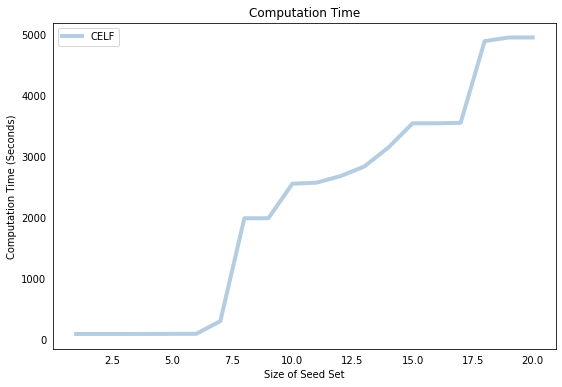

In [58]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_general_threshold[2])+1),celf_output_general_threshold[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

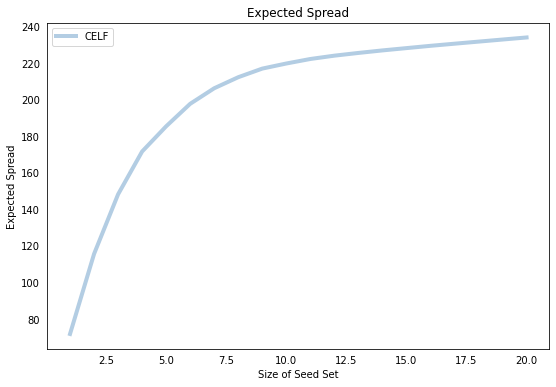

In [30]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_general_threshold[1])+1),celf_output_general_threshold[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Linear Threshold Mode

In [31]:
linear_threshold = models.linear_threshold()
linear_threshold.fit(G)

p_linear_threshold = linear_threshold.influence[linear_threshold.influence != 0]
celf_output_linear_threshold= celf(pb2020, 20, p = np.mean(p_linear_threshold), mc = 100)

In [32]:
pickle_linear_threshold = pickle.dumps(celf_output_linear_threshold)

with open('pickle_linear_threshold.pickle', 'wb') as handle:
    pickle.dump(pickle_linear_threshold, handle)

In [33]:
with open('linear_threshold.json', 'w') as fjson:
    json.dump(celf_output_linear_threshold, fjson)

In [59]:
f = open('linear_threshold.json')
celf_output_linear_threshold = json.load(f)
li = celf_output_linear_threshold[0]

for i in li:
    print(AAAA.vs['label'][i])

principe_giovan
Premises187
MoralDK
proudboy_
enrique_tarrio
GavinM_ProudBoy
proudboy2012
ProudBoysGBG
ProudBoysUS
ProudBoyzLondon
DetroitProudBoy
Father_Rhyme
ColoradoPOYB
cckrch
decentbastards
Proudboy13
American_Greg
GregoryKuhnJr1
Sj71Steven
usa_chopper


In [34]:
print("The optimal seed set is: ", celf_output_linear_threshold[0])
print("The resulting spread is: ", celf_output_linear_threshold[1])
print("The time for each iteration is: ", celf_output_linear_threshold[2])
print("The number of times the spread is computed is: ", celf_output_linear_threshold[3])

The optimal seed set is:  [6310, 1916, 1596, 7251, 37, 1493, 7157, 7456, 7508, 8020, 21, 1485, 0, 8675, 6349, 7154, 11242, 11989, 7471, 2074]
The resulting spread is:  [71.85, 115.59, 148.19, 171.6, 185.37, 197.67, 206.17, 212.21, 216.92, 219.7, 222.17, 223.99, 225.48, 226.86, 228.12, 229.37, 230.53, 231.67, 232.81, 233.94]
The time for each iteration is:  [73.4015576839447, 73.5800564289093, 73.81907296180725, 74.08768010139465, 75.28535914421082, 76.17710900306702, 243.90924191474915, 1782.837567806244, 1783.1775259971619, 2231.054145336151, 2249.0770626068115, 2338.9165830612183, 2499.2617180347443, 2794.873381137848, 3162.9981949329376, 3163.3145003318787, 3169.1303074359894, 4564.828184843063, 4627.633970499039, 4628.259597063065]
The number of times the spread is computed is:  [13217, 1, 1, 1, 4, 3, 603, 4705, 1, 1433, 41, 255, 484, 912, 1151, 1, 18, 4038, 184, 2]


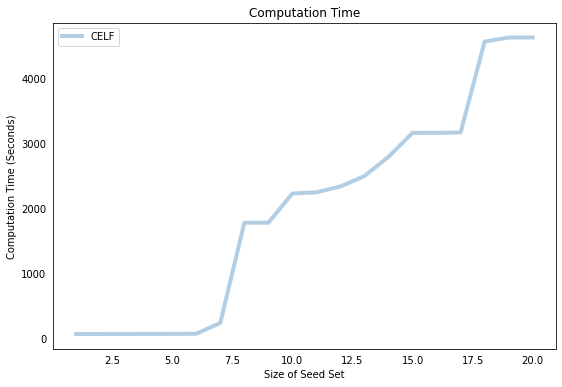

In [60]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_linear_threshold[2])+1),celf_output_linear_threshold[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

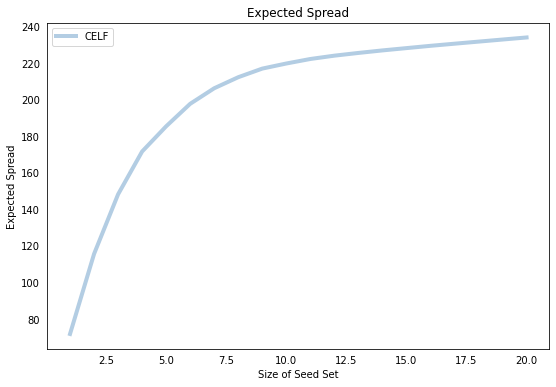

In [36]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_linear_threshold[1])+1),celf_output_linear_threshold[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Plots